# Гасанов Эльмир ПИ18-3 ДТЗ

# Парсинг сайта https://av.by/

In [20]:
from bs4 import BeautifulSoup
import requests
import csv

URL = "https://cars.av.by/filter?price_currency=2&page="
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36 OPR/73.0.3856.344"}

def writeCsv(comps):
    with open("data.csv", 'w', newline='', encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile, delimiter=";")
        for comp in comps:
            writer.writerow([str(comp["Name"]),
                             str(comp["Price"]),
                             str(comp["Year"]),
                             str(comp["Transmission"]),
                             str(comp["Volume"]),
                             str(comp["Fuel"]),
                             str(comp["Mileage"])
            ])

def parse():
    count = 0
    comps = []
    for i in range(1, 150):
        count += 1
        response = requests.get(URL + str(i), headers=HEADERS)
        soup = BeautifulSoup(response.content, "html.parser")
        items = soup.findAll("div", class_="listing-item")
        for item in items:

            info = item.find("div", class_="listing-item__params").get_text(strip=True)

            splited_info = info.replace("\xa0", '').replace(",", ' ').replace("г.", ' ').split(' ')

            if splited_info[1][0] == "а":
                transmission = "auto"
            else:
                transmission = "mech"

            if splited_info[2] == "электро":
                volume = "-"
                fuel = "Elec"
            else:
                volume = splited_info[2][0:len(splited_info[2])-1]
                if splited_info[3][0] == "б":
                    fuel = "Benz"
                else:
                    fuel = "Diz"

            mileage = info[len(info) - 10:len(info) - 3].replace(" ", '')
            while not mileage.isdigit():
                mileage = mileage[1::1]

            comps.append({
                "Name": item.find("span", class_="link-text").get_text(strip=True),
                "Price": item.find("div", class_="listing-item__price").get_text(strip=True)[0:len(item.find("div", class_="listing-item__price").get_text(strip=True)) - 3],
                "Year": item.find("div", class_="listing-item__params").get_text(strip=True)[0:4],
                "Transmission": transmission,
                "Volume": volume,
                "Fuel": fuel,
                "Mileage": mileage
            })
        print(count)

    writeCsv(comps)


if __name__ == '__main__':
    parse()


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


# Работа с данными

Не смотря на то, что я записывал файл в кодировке utf-8, все равно перед тем, как запускать код ниже- нужно пересохранить csv-файл с кодировкой utf-8 вручную.

Импортирую нужные библиотеки

In [136]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

In [137]:
data = pd.read_csv('data1.csv', sep=';', encoding='utf-8', 
                   names=['name', 'price', 'year', 'type', 'consumption', 'fuel_type', 'mileage'], index_col= 'name')

In [138]:
data = data.drop('consumption', axis = 1)
data.head()

,price,year,type,fuel_type,mileage
name,,,,,
"DodgeGrand CaravanIV,7В РјРµСЃС‚",11461,2001,auto,Benz,280025
BMW5 СЃРµСЂРёСЏF07 (GT),42543,2011,auto,Benz,169000
RenaultLoganII В· Р РµСЃС‚Р°Р№Р»РёРЅРі,20890,2019,mech,Benz,43000
Land RoverRange RoverIV,115911,2012,auto,Diz,150000
"OpelSintra,7В РјРµСЃС‚",6624,1998,mech,Benz,415000


Моей задачей будет предсказать цену на автомобиль. Воспользуюсь для этого методами регрессии библиотеки sklearn

In [139]:
data.shape

(3000, 5)

Небольшая описательная статистика распределения числовых данных датасета

In [140]:
data.describe()

,price,year,mileage
count,3000.000000,3000.000000,3000.000000
mean,22115.655333,2005.951667,228957.595667
std,19819.682190,7.610079,123427.050629
min,100.000000,1960.000000,1.000000
25%,9423.000000,2001.000000,141000.000000
50%,17068.000000,2007.000000,222000.000000
75%,28054.750000,2012.000000,310000.000000
max,203545.000000,2020.000000,999999.000000


Проверяю, есть ли пропущенные значения. Их нет. Если бы были-их можно удалить методом dropna()

In [141]:
data.isna().sum()

price        0
year         0
type         0
fuel_type    0
mileage      0
dtype: int64

Хитмап по корреляции внутри данных датасета. Отрицательная корреляция между годом выпуска автомобиля и его пробегом. То же самое и с ценой относительно пробега и года выпуска. Логично.

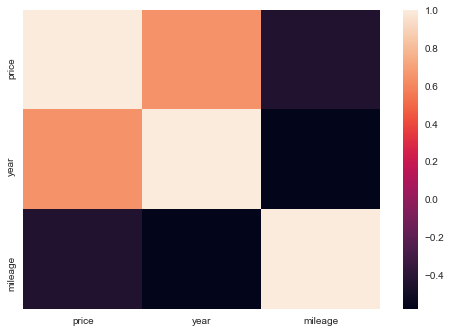

In [142]:
sns.heatmap(data.corr())

То же самое,только с конкретными числами

In [143]:
data.corr()

,price,year,mileage
price,1.000000,0.643133,-0.446103
year,0.643133,1.000000,-0.582916
mileage,-0.446103,-0.582916,1.000000


Строю гистограммы распределений и ящики с усами по численным данным.

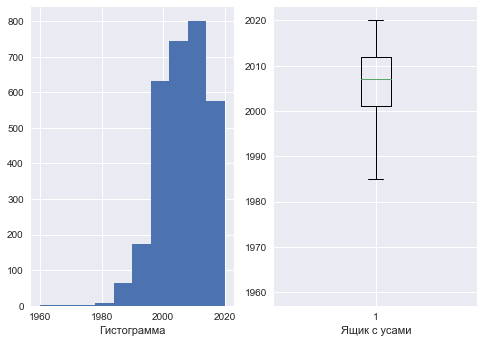

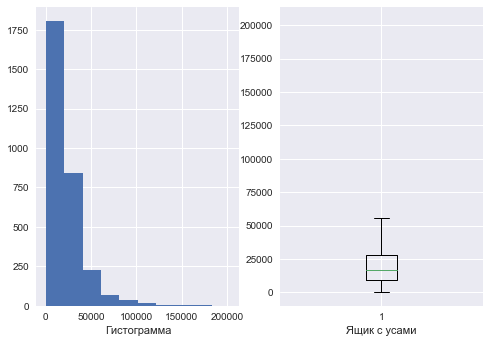

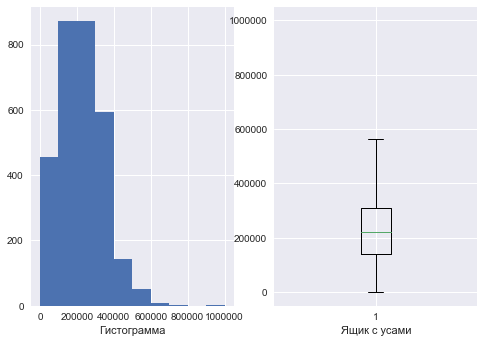

In [144]:
for i in [data.year, data.price, data.mileage]:
    fig, ax = plt.subplots(1, 2)
    ax[0].hist(i)
    ax[0].set_xlabel('Гистограмма')
    ax[1].boxplot(i)
    ax[1].set_xlabel('Ящик с усами')

Как можно заметить, год и пробег распределены нормально, что касается цены- тут правая половина нормального распределения. Связано это с тем, что в целом по статистике дешевых автомобилей на вторичном рынке больше, чем дорогих и автомобилей среднего ценового сегмента, так как даже автомобили премиум- класса при многочисленной перепродаже становятся дешевыми с годами.

Нужно сделать дамми-переменные из столбцов с типом топлива, годом выпуска и типом коробки передач

По хорошему стоит удалить из выборки автомобили, выпущенные ранее 1985 года, так как их достаточно мало, а добавлять из за них лишние колонки- не лучшая идея.

In [145]:
data.drop(data[ (data.year < 1985)].index, axis=0, inplace=True)
data.head()

,price,year,type,fuel_type,mileage
name,,,,,
"DodgeGrand CaravanIV,7В РјРµСЃС‚",11461,2001,auto,Benz,280025
BMW5 СЃРµСЂРёСЏF07 (GT),42543,2011,auto,Benz,169000
RenaultLoganII В· Р РµСЃС‚Р°Р№Р»РёРЅРі,20890,2019,mech,Benz,43000
Land RoverRange RoverIV,115911,2012,auto,Diz,150000
"OpelSintra,7В РјРµСЃС‚",6624,1998,mech,Benz,415000


In [146]:
data = pd.get_dummies(data, columns=['year', 'fuel_type', 'type'])
data.head()

,price,mileage,year_1985,year_1986,year_1987,year_1988,year_1989,year_1990,year_1991,year_1992,...,year_2016,year_2017,year_2018,year_2019,year_2020,fuel_type_Benz,fuel_type_Diz,fuel_type_Elec,type_auto,type_mech
name,,,,,,,,,,,,,,,,,,,,,
"DodgeGrand CaravanIV,7В РјРµСЃС‚",11461,280025,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
BMW5 СЃРµСЂРёСЏF07 (GT),42543,169000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
RenaultLoganII В· Р РµСЃС‚Р°Р№Р»РёРЅРі,20890,43000,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
Land RoverRange RoverIV,115911,150000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
"OpelSintra,7В РјРµСЃС‚",6624,415000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [156]:
data.shape

(2969, 43)

Удалена всего 31 строка, но при этом удалось значительно уменьшить количество dummy-переменных.

Теперь у нас 42 колонки фичей и колонка целевой переменной price


# Далее- модели.

Разбиваю датасет

In [147]:
X = data.drop('price', axis=1)
y = data['price']

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Обычная линейная регрессия без гиперпараметров

In [155]:
regr = LinearRegression()
regr.fit(X_train, y_train)

y_pred_train = regr.predict(X_train)
mse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"train mse: {mse}")
print(regr.score(X_train, y_train))
y_pred_test = regr.predict(X_test)
mse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"mse: {mse}")
print('r2: ', regr.score(X_test, y_test))

train mse: 15821.218808530051
0.3820580340534884
mse: 14311.295911043982
r2:  0.4305538409602212


Если в линейной регрессии выше SVD не сойдется, нужно просто перезапустить его.

Корень из средней квадратичной ошибки 14299 у.е. при средней цене на авто 22115.65 у.е.- вполне неплохо для обычной линейной регрессии. Но Р-квадрат низковат. Модель не переобучена.

Попробую так же и Ансамбль решающих деревьев, без гиперпараметров. Обычно он справляется значительно лучше.

In [150]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

y_pred_train = regr.predict(X_train)
mse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"train mse: {mse}")
print(regr.score(X_train, y_train))
y_pred_test = regr.predict(X_test)
mse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"mse: {mse}")
print('r2: ', regr.score(X_test, y_test))

train mse: 5578.930111710807
0.9222203588034281
mse: 14034.006451504245
r2:  0.4739054764077183


Ожидаемо, на трейновой выборке RandomForest без ораничения max_depth и прочих гиперпараметров переобучился и показал результат не сильно лучше, чем линейная регрессия.

In [151]:
best_mse = 20000
best_r2 = -1
for i in range(3,15):
    pca = PCA(n_components=i)
    X_new = pca.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=47)
    
    regr = RandomForestRegressor()

    regr.fit(X_train, y_train)
    y_pred_test = regr.predict(X_test)
    
    mse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    
    if best_mse > mse:
        best_mse = mse
    if best_r2 < r2:
        best_r2 = r2
        
    print("mse: {} r2: {} Количество компонент: {}".format(best_mse, best_r2, i))

mse: 13925.535708366759 r2: 0.4608388794539702 Количество компонент: 3
mse: 12981.85463995037 r2: 0.5314367442897114 Количество компонент: 4
mse: 12981.85463995037 r2: 0.5314367442897114 Количество компонент: 5
mse: 12695.603524855405 r2: 0.5518726533869809 Количество компонент: 6
mse: 12695.603524855405 r2: 0.5518726533869809 Количество компонент: 7
mse: 12695.603524855405 r2: 0.5518726533869809 Количество компонент: 8
mse: 12695.603524855405 r2: 0.5518726533869809 Количество компонент: 9
mse: 12695.603524855405 r2: 0.5518726533869809 Количество компонент: 10
mse: 12695.603524855405 r2: 0.5518726533869809 Количество компонент: 11
mse: 12695.603524855405 r2: 0.5518726533869809 Количество компонент: 12
mse: 12695.603524855405 r2: 0.5518726533869809 Количество компонент: 13
mse: 12695.603524855405 r2: 0.5518726533869809 Количество компонент: 14


Как можно заметить, качество перестало расти после 6 компонент. Следовательно останавливаюсь на 7 компонентах и попытаюсь перебрать гиперпараметры на гриде. Random state использовал для того, чтобы рандом при разбиении датасета не вносил путаницу.

Сетка гиперпараметров для GridSearchCV

In [152]:
params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2,3,4,5],
    'min_samples_split': [3,5,],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [153]:
pca = PCA(n_components=6)
X_new = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=47)

regr = RandomForestRegressor(n_jobs=-1)

regr_grid_search = GridSearchCV(regr, params, cv=3, n_jobs=-1, verbose=True)

regr_grid_search.fit(X_train, y_train)

print(regr_grid_search.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   17.3s finished


{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 200}


Метрики качества

In [154]:
y_pred_train = regr_grid_search.predict(X_train)
mse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"train mse: {mse}")
print(regr_grid_search.score(X_train, y_train))
y_pred_test = regr_grid_search.predict(X_test)
mse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"mse: {mse}")
print('r2: ', regr_grid_search.score(X_test, y_test))

train mse: 13144.445959741472
0.5734672458978016
mse: 12062.4155656028
r2:  0.5954582791825515


Немного удалось улучшить результат, относительно RandomForest без гиперпараметров и PCA. Так же избавился от сильного переобучения.

Стоит упомянуть о проблеме метода главных компонент- он "обезличивает" наши признаки, всвязи с чем, исследователь данных больше не может сказать, какая из фич конкретно наибольшим образом повлияла на результат предсказания модели. Для просмотра того, насколько сильно компоненты объясняют исходные данные можно использовать pca.explained_variance_ratio_, а для просмотра влияния новых фич, преобразованных pca- feature_importances_)

In [159]:
pca.explained_variance_ratio_

array([1.00000000e+00, 3.33619977e-11, 2.59458514e-11, 4.03636721e-12,
       3.64323858e-12, 3.36948541e-12])

In [158]:
regr = RandomForestRegressor(n_jobs=-1, max_depth= 5, max_features= 'log2', min_samples_split= 5, n_estimators= 200)
regr.fit(X_train, y_train)
regr.feature_importances_

array([0.25544767, 0.15680105, 0.28952838, 0.0869093 , 0.14787565,
       0.06343795])

Данные для работы были получены парсингом автомобильного сайта https://av.by/

Был проведен анализ скачанных данных:

* Визуальный обзор и последующий анализ признаков

* Обработка категориальных признаков (сделал из них дамми-переменные)

* Просмотр распределений данных, как методом describe, хитмапа корреляций так и при помощи гистограмм и ящиков с усами.

* Удаление нескольких строк данных для последующего создания дамми-переменных.

Проанализировав графики, пришел к выводу о том, что все зависимости вполне закономерны.
Обучение без учителя (метод главных компонент) использовал с помощью метода PCA библиотеки Sklearn и ее документации.

Далее на Gridsearch перебрал гиперпараметры, устранил ранее замеченное переобучение и пришел к тому, что помимо явного выигрыша в скорости обучения, PCA в купе с гридом улучшил предсказательную силу модели.